# Понятие переобучения

## Исходные данные

Для этого занятия нам понадобится файл `non_linear.csv` который хранится в [директории курса на Google Drive](https://drive.google.com/file/d/1prHJVpHn0N5y1BqLQQ2Hpx5OP8uKIXjT/view?usp=sharing)

Скопируйте файл к себе в родительскую директорию **hse_nlp_2021**

In [2]:
import logging
import os
import shutil 

import numpy as np
from google.colab import drive

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info('Инициализировали логгер')

ROOT_DIR = '/content/drive' 
drive.mount(ROOT_DIR)
logger.info('Подключили диск')

root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', 'hse_nlp_2021')
if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  logger.info('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir))

2022-01-31 06:52:55,992 : INFO : Инициализировали логгер
2022-01-31 06:53:20,592 : INFO : Подключили диск


Mounted at /content/drive


2022-01-31 06:53:20,841 : INFO : Содержимое директории /content/drive/MyDrive/hse_nlp_2021: ['events.csv', 'corpora', 'nltk_data_old', 'nltk_data', '1000k_memes_ocr.tar.gz', 'logs', 'sklearn_data', 'nyt-ingredients-snapshot-2015.csv', 'insurance.csv', 'non_linear.csv', 'my_little_recsys', 'optimal_push_time']


# I Переобучение

## Как детектировать переобучение

Переобучение - это явление, когда модель "слишком сильно" подгоняется под обучающую выборку и плохо справляется с новыми данными - проведём эксперимент и увидим на примере линейной регрессии, как переобучаются модели

Начнем с исходных данных - их мы уже исследовали на прошлом семинаре

In [3]:
import os

import numpy as np
import pandas as pd

raw_data_file = os.path.join(root_data_dir, 'non_linear.csv')
data = pd.read_csv(raw_data_file, sep=',')

data.head()

,x_train,y_train
0,0.138368,0.838812
1,0.157237,0.889313
2,0.188684,1.430040
3,0.685553,1.717309
4,0.874237,2.032588


Визуализируем с помощью scatter

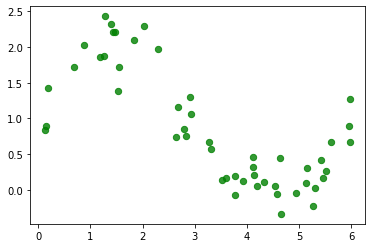

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
# основной график
plt.scatter(data.x_train, data.y_train, 40, 'g', 'o', alpha=0.8)
plt.show()

Цель - научиться определять переобучение.

Тренироваться будем на полиномиальной регрессии. То есть регрессия-то будет линейная, но нужно будет сгенерить для каждого x признаки $x^2,\cdots, x^n$ и добавить в матрицу объекты-признаки $X$ несколько столбцов - степени фичей (например, в случае обучения регрессии на единственной фиче модуль приобретёт вид $y = w_0 + w_1x +w_2x^2 + \ldots + w_nx^n$).

То есть пространство функций у нас линейное, увеличивается количество только коэффициентов $w$

$$
\forall x_i: h(x) =  \sum_{j=1}^{n}w_jx_i^j
$$

Матрица, состоящая из степеней $x$ называется [матрицей Вандермондта](https://en.wikipedia.org/wiki/Vandermonde_matrix), реализация этой матрицы есть в `numpy`. 

In [7]:
def generate_powers(x, N):
  return np.vander(x, N=N, increasing=True)[:,1:]

generate_powers(data.head(3).x_train.values, N=5)

array([[0.13836845, 0.01914583, 0.00264918, 0.00036656],
       [0.15723687, 0.02472343, 0.00388744, 0.00061125],
       [0.18868424, 0.03560174, 0.00671749, 0.00126748]])

Обучаем модель на валидации, проверяем на контроле для степени полинома `degree=8` (думаю, степень полинома можно назвать гиперпараметром). Для разбиения мы воспользуемся функцией [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

* $X$ и $y$ - массивы, которые хотим расщепить на валидацию и контроль
* *test_size* принимает значения от нуля до единицы и означает долю объектов, которые нужно отложить на валидацию (обычно выбирают значения между $0.15$ и $0.35$)
* *random_state* - любое целое число, если задано то разбиение не будет меняться в разных запусках программы (нужно для воспроизводимости). Мы используем константу `RANDOM_SEED` 

Обучать будем линейную регрессию из класса [sklearn.linear_model.Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). Вообще-то Ridge оптимизирует немного другой функционал, не совсем как в линейной регрерсии:

$$
\|Y - Xw\|^2_2 + \alpha \cdot \|w\|^2_2
$$

Поэтому будем обучать при $\alpha = 0$ чтобы получилась обычная линейная регрессия

Норма весов рассчитывается

$$
\|w\|^2_2 = w_0^2+w_1^2 + \ldots+w_n^2
$$

Для вычисления такой нормы можно использовать [функцию norm из numpy](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.linalg.norm.html)

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso  # импортируем новые для на модели
from sklearn.model_selection import train_test_split

degree = 8

# извлекаем признаки
X = generate_powers(data.x_train.values, N=degree)
y = data.y_train.values

# разделяем на обучающую и валидационную выборку
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# обучаем модель
model = Ridge(alpha=0).fit(X_train, y_train)

# получаем предсказания
y_pred = model.predict(X_valid)
y_pred_train = model.predict(X_train)

print("Качество на обучении: %.3f" % mean_squared_error(y_train, y_pred_train))
print("Качество на валидации: %.3f" % mean_squared_error(y_valid, y_pred))

Качество на обучении: 0.072
Качество на валидации: 0.040


Теперь обучим полиномиальную регрессию для степени `degree = 12` c параметром регуляризации `alpha=0`

In [9]:
degree = 12
X = generate_powers(data.x_train.values, N=degree)
y = data.y_train.values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
model = Ridge(alpha=0).fit(X_train, y_train)

y_pred = model.predict(X_valid)
y_pred_train = model.predict(X_train)

print("Качество на обучении: %.3f" % mean_squared_error(y_train, y_pred_train))
print("Качество на валидации: %.3f" % mean_squared_error(y_valid, y_pred))

Качество на обучении: 0.064
Качество на валидации: 0.050


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.60961e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Как изменилась ошибка на обучении? Было $0.072$, стало $0.064$, т.е. *ошибка на обучении падает*.

Как изменилась ошибка на валидации? Было $0.04$, стало $0.05$, т.е. *ошибка на валидации растёт*.

Это и есть признак переобучения (выспоминаем графики) - ошибка на валидации растёт, а на обучении падает, степень полинома $n=12$ хуже, чем степень полинома $n=8$, модель переобучилась.

#### Самостоятельная работа

У класса *Ridge* в конструкторе есть параметр регуляризации - обучите регрессию при $\alpha=0.4$ для степени полинома 12

Как изменилась ошибка на обучении? Как изменилась ошибка на валидации? Удалось ли победить переобучение?

In [10]:
degree = 12
alpha = 0.4

# -- ВАШ КОД ТУТ ---



# ------------------

Переобучение - это плохо. Мы начинаем слишком сильно подгоняться под обучающую выборку и плохо "готовы" к новым данным. Детектировать можно с помощью валидационной выборки. Победить переобучение можно с помощью регуляризации в библиотечном классе Ridge

### Самостоятельная работа: Lasso vs Ridge

В стандартной библиотеке есть ещё интересный класс [sklearn.linear_model.Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)

$$
\|Y - Xw\|^2_2 + \alpha \cdot \|w\|_1
$$

Норма весов рассчитывается по формуле

$$
\|w\|_1 = |w_0|+|w_1| + \ldots+|w_n|
$$

Для вычисления этой метрики используем [функцию norm из numpy](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.linalg.norm.html)

На данных из файла `data/non_linear.csv`
* сгенерируйте данные для степени `degree = 8`
* обучите модель `sklearn.linear_model.Lasso` и модель `sklearn.linear_model.Ridge` на полученных данных
* используйте коэффициент регуляризации $\alpha=0.8$ для обеих моделей
* постройте два столбчатых графика, на которых отобразите величину коэффициентов в для Ridge регрессии и Lasso регрессии виде столбиков

In [8]:
# -- ВАШ КОД ТУТ ---



# -------------------

Мы использовали реализацию Ridge регрессию из библиотеки sklearn. Для того, чтобы  прокачать навыки программирования и освежить в памяти, как перемножать матрицы в numpy, напишите код для вычисления коэффициентов полиномиальной регрессии (для степени *degree=8*) с регуляризацией по формуле
$$
\overline{w} = \left(X^TX + \lambda E\right)^{-1}X^T\overline{y}
$$

Сравните расхождение `model.intercept_ + model.coef_` с вашими коэффициентами

Не забудьте добавить столбец из единиц к маатрице фичей! 

In [34]:
# -- ВАШ КОД ТУТ ---



# -------------------

# Переобучение на валидационной выборке

Посмотрим в динамике

2022-01-31 07:46:01,498 : INFO : N=3	 valid err 0.245	 train err 0.314	||w|| = 0.47


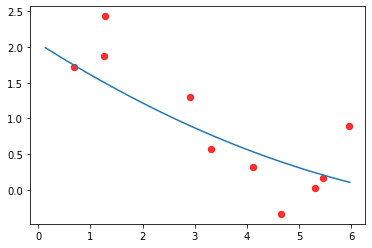

2022-01-31 07:46:01,768 : INFO : N=5	 valid err 0.063	 train err 0.069	||w|| = 3.23


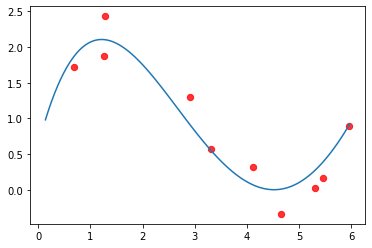

2022-01-31 07:46:02,157 : INFO : N=7	 valid err 0.067	 train err 0.066	||w|| = 3.54


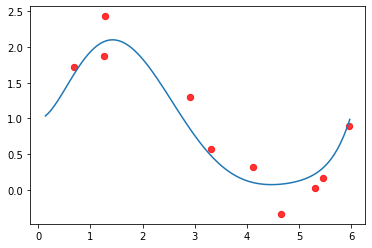

2022-01-31 07:46:02,618 : INFO : N=10	 valid err 0.123	 train err 0.052	||w|| = 93.44


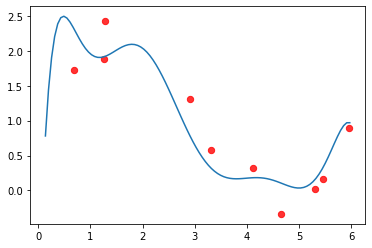

In [27]:
from sklearn.linear_model import LinearRegression
from numpy.linalg import norm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def fit_regression(x_train, x_valid, y_train, y_valid):
    model = LinearRegression().fit(x_train, y_train)
    # ошибки на обучении и валидации
    y_pred = model.predict(x_valid)
    y_pred_train = model.predict(x_train)
    # для графиков
    error_valid = mean_squared_error(y_valid, y_pred)
    error_train = mean_squared_error(y_train, y_pred_train)
    w_norm = norm(model.coef_)

    return error_valid, error_train, w_norm, model

def train_polynomial(degrees, data):
    """Генерим данные, тренируем модель  
    дополнительно рисуем график
    """
    x_linspace = np.linspace(data['x_train'].min(), data['x_train'].max(), num=100)
    y = data.y_train.values

    degrees, valid_errors, train_errors, w_norm = [], [], [], []
    for degree in (3, 5, 7, 10):
        # генерим фичи
        X = generate_powers(data.x_train.values, N=degree)
        # обучение и контроль зависят от степени полинома, т.к. меняется размерность
        X_train, X_valid, y_train, y_valid = (
            train_test_split(
                X, y,
                test_size=0.2, random_state=10
            )
        )
        order_test = np.argsort(X_valid[:,0])
        # ошибка на тренировочном сете
        error_valid, error_train, coef_norm, model = fit_regression(X_train, X_valid, y_train, y_valid)
        logger.info(
            "N=%d\t valid err %.3f\t train err %.3f\t||w|| = %.2f",
            degree, error_valid, error_train, norm(model.coef_)
        )
        plt.scatter(X_valid[:,0][order_test], y_valid[order_test], 40, 'r', 'o', alpha=0.8)
        # визуализируем решение
        y_linspace = model.predict(generate_powers(x_linspace, N=degree))
        plt.plot(x_linspace, y_linspace)
        plt.show()
        valid_errors.append(error_valid)
        train_errors.append(error_train)
        w_norm.append(coef_norm)
    return valid_errors, train_errors, w_norm

DEGREES = (3, 5, 7, 10)
valid_errors, train_errors, w_norm = train_polynomial(
    degrees=DEGREES, data=data
)

В этом абстрактном эксперименте: видны следующие закономерности

* степень полинома растёт $\rightarrow$ ошибка на тренировочных данных падает
* степень полинома растёт $\rightarrow$ ошибка на валидации растёт
* степень полинома растёт $\rightarrow$ сумма квадратов коэффициентов регрессии растёт

Т.е. можно детектировать переобучение, если проверять такую прокси-метрику как "норма весов регрессии"
* по оси $oX$ - степень полинома
* по оси $oY$ - ошибка на валидации и ошибка на обучении

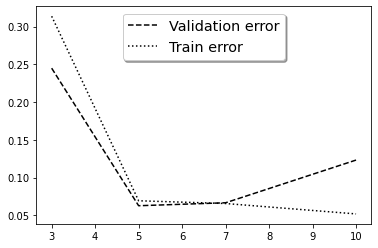

In [28]:
from matplotlib import pyplot
%matplotlib inline

fig, ax = plt.subplots()
ax.plot(DEGREES, valid_errors, 'k--', label='Validation error')
ax.plot(DEGREES, train_errors, 'k:', label='Train error')

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')


plt.show()

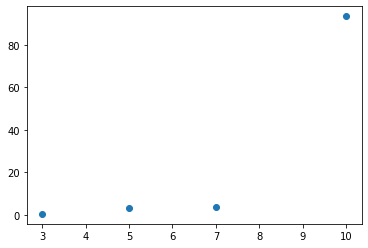

In [30]:
plt.scatter(DEGREES, w_norm)
plt.show()

Самостоятельное задание: подберите наилучший alpha с помощью [cross_val_score](https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics)

In [1]:
# -- ВАШ КОД ТУТ ---



# ------------------